<h1><center>Predicting the Sale Price of Bulldozer using Machine Learning</h1></center>

<img src="data/bulldozer.jpg">

## Problem Definition

The goal of this project is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration. As the machine learning model has to predict a number and not a category, this kind of problem is known as **regression problem**.

In a statement:

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## Data

The data is downloaded from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data).

The data is sourced from auction result postings and includes information on usage and equipment configurations.
It has historical sales data of bulldozers, including things like, model type, size, sale date and more.

It's a time series problem, we´re using past events to try and predict future events, so there's a time attribute to dataset. 

There are 3 main datasets:

* `Train.csv` - Training set, which contains data through the end of 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the target variable).
* `Valid.csv` - Validation set, which contains data from January 1, 2012 - April 30, 2012 (close to 12,000 examples with the same attributes as Train.csv; but doesn´t have the `SalePrice` label).
* `TrainAndValid.csv` - Both `Train.csv` and `Valid.csv` with the `SalePrice` label. I´ll work with this dataset.
* `Test.csv` - It contains data from May 1, 2012 - November 2012 (close to 12,000 examples but missing the `SalePrice` label, as this is what I'll be trying to predict).

## Evaluation Metric

As the goal for most regression evaluation metrics is to minimize the error, the evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

# Preparing the tools

I'll be going to use pandas, Matplotlib and NumPy for data analysis and manipulation.
For the machine learning model, I use SciKit-Learn.

In [1]:
# Import utility
import re

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Model from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

# Load Data

In [2]:
df_orig = pd.read_csv("data/TrainAndValid.csv", 
                       low_memory=False, 
                       parse_dates=["saledate"])
df_test = pd.read_csv("data/Test.csv", 
                       low_memory=False, 
                       parse_dates=["saledate"])

print(f"TrainAndValid dataset shape: {df_orig.shape}")
print(f"Test dataset shape: {df_test.shape}")

TrainAndValid dataset shape: (412698, 53)
Test dataset shape: (12457, 52)


## Features

There are 53 variables in the dataset. The key fields are:

* `SalesID`: the unique identifier of the sale.
* `MachineID`: the unique identifier of a machine. A machine can be sold multiple times.
* `saleprice`: what the machine sold for at auction (only provided in train.csv).
* `saledate`: the date of the sale.

There are several fields on the different options a machine can have. The descriptions all start with "machine configuration" in the data dictionary. Some product types do not have a particular option, so all the records for that option variable will be null for that product type. Also, some sources do not provide good option and/or hours data.

<br>
<details> <summary><b>Click here to see the data dictionary</b></summary>
    
| Variable | Description |
|:---:|:---|
| `SalesID` | unique identifier of a particular sale of a machine at auction |
| `MachineID` | identifier for a particular machine;  machines may have multiple sales |
| `ModelID` | identifier for a unique machine model (i.e. fiModelDesc) |
| `datasource` | source of the sale record;  some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs. |
| `auctioneerID` | identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource. |
| `YearMade` | year of manufacturer of the machine |
| `MachineHoursCurrentMeter` | current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale |
| `UsageBand` | value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel. |
| `saledate` | time of sale |
| `saleprice` | cost of sale in USD |
| `fiModelDesc` | Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor |
| `fiBaseModel` | disaggregation of fiModelDesc |
| `fiSecondaryDesc` | disaggregation of fiModelDesc |
| `fiModelSeries` | disaggregation of fiModelDesc |
| `fiModelDescriptor` | disaggregation of fiModelDesc |
| `ProductSize` | The size class grouping for a product group. Subsets within product group. |
| `fiProductClassDesc` | description of 2nd level hierarchical grouping (below ProductGroup) of fiModelDesc |
| `State` | US State in which sale occurred |
| `ProductGroup` | identifier for top-level hierarchical grouping of fiModelDesc |
| `ProductGroupDesc` | description of top-level hierarchical grouping of fiModelDesc |
| `Drive_System` | machine configuration;  typcially describes whether 2 or 4 wheel drive |
| `Enclosure` | machine configuration - does machine have an enclosed cab or not |
| `Forks` | machine configuration - attachment used for lifting |
| `Pad_Type` | machine configuration - type of treads a crawler machine uses |
| `Ride_Control` | machine configuration - optional feature on loaders to make the ride smoother |
| `Stick` | machine configuration - type of control |
| `Transmission` | machine configuration - describes type of transmission;  typically automatic or manual |
| `Turbocharged` | machine configuration - engine naturally aspirated or turbocharged |
| `Blade_Extension` |	machine configuration - extension of standard blade |
| `Blade_Width` |	machine configuration - width of blade |
| `Enclosure_Type` | machine configuration - does machine have an enclosed cab or not |
| `Engine_Horsepower` | machine configuration - engine horsepower rating |
| `Hydraulics` | machine configuration - type of hydraulics |
| `Pushblock` | machine configuration - option |
| `Ripper` | machine configuration - implement attached to machine to till soil |
| `Scarifier` | machine configuration - implement attached to machine to condition soil |
| `Tip_control` |	machine configuration - type of blade control |
| `Tire_Size` | machine configuration - size of primary tires |
| `Coupler` |	machine configuration - type of implement interface |
| `Coupler_System` | machine configuration - type of implement interface |
| `Grouser_Tracks` | machine configuration - describes ground contact interface |
| `Hydraulics_Flow` | machine configuration - normal or high flow hydraulic system |
| `Track_Type` | machine configuration - type of treads a crawler machine uses |
| `Undercarriage_Pad_Width` | machine configuration - width of crawler treads |
| `Stick_Length` | machine configuration - length of machine digging implement |
| `Thumb` | machine configuration - attachment used for grabbing |
| `Pattern_Changer` |	machine configuration - can adjust the operator control configuration to suit the user |
| `Grouser_Type` | machine configuration - type of treads a crawler machine uses |
| `Backhoe_Mounting` | machine configuration - optional interface used to add a backhoe attachment |
| `Blade_Type` | machine configuration - describes type of blade |
| `Travel_Controls` |	machine configuration - describes operator control configuration |
| `Differential_Type` | machine configuration - differential type, typically locking or standard |
| `Steering_Controls` | machine configuration - describes operator control configuration |
    
</details>
<br>

#  Exploratory Data Analysis

As there are a lot of features in the dataset, here I´ll only check the info, datatypes, head, and _NaNs_ in there. An EDA of the features will be made after building a model and looking at the Feature Importance.

In [3]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [4]:
df_orig.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [5]:
# Calculating the percentage of NaN values
df_orig.isna().sum().apply(lambda x: f"{(x*100/(len(df_orig))):.2f}%").sort_values(ascending=False)

Tip_Control                 93.70%
Blade_Extension             93.70%
Blade_Width                 93.70%
Enclosure_Type              93.70%
Engine_Horsepower           93.70%
Pushblock                   93.70%
Scarifier                   93.70%
Hydraulics_Flow             89.13%
Grouser_Tracks              89.13%
Coupler_System              89.10%
fiModelSeries               85.78%
Steering_Controls           82.67%
Differential_Type           82.66%
UsageBand                   82.15%
fiModelDescriptor           81.87%
Backhoe_Mounting            80.44%
Pad_Type                    80.35%
Stick                       80.35%
Turbocharged                80.35%
Travel_Controls             80.16%
Blade_Type                  80.16%
Tire_Size                   76.34%
Track_Type                  75.24%
Grouser_Type                75.24%
Pattern_Changer             75.22%
Stick_Length                75.22%
Thumb                       75.20%
Undercarriage_Pad_Width     75.06%
Ripper              

## Preprocesing dataset // Feature Engineering

To proceed with the machine learning model building, we have to turn all of our data into numbers and there can´t be any missing values. I will:

* Enrich the dataset with time features extracted from the original `saledate` datetime.
* Fill the _NaN_ values of the numeric features with the median value.
* Add a new boolean (or binary) features to indicate those numeric rows who had missing values.
* If there is 7 or more uniques values, convert the columns with string datatype into 'Category' datatype and then to a numeric one.
* From the string datatype columns that less than 7 or uniques values, I´ll create dummies

Also, as our model must be trained on training data and validated with a validation dataset, we will split the original dataset. Those must be formatted in the same way, as well as the test dataset.

**Time Features Extraction Step**

When working with time series data, it's a good idea to make sure any date data is the format of a datetime object (a Python data type which encodes specific information about dates).

Also, as we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date. 

As we are working with a date-time feature, the `add_datepart` method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. Without expanding the date-time into these additional fields, we can’t capture any trend/cyclical behavior as a function of time at any of these granularities. With this, we can enrich a bit our dataset with as much information as possible.

In [6]:
def add_datepart(df, fldname, drop=True):
    # New features to make from the date feature
    new_features = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 
                    'Dayofyear', 'Is_month_end', 'Is_month_start', 
                    'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
                    'Is_year_start']
    
    fld = df[fldname]
    
    # Make sure that the feature dtype is datetime
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    # Delete the "date" substring from the feature title
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    # Add the new features
    for feature in new_features:
        df[targ_pre+feature] = getattr(fld.dt, feature.lower())  # look inside of an object and find an attribute with that name

    
    # the number of days since the first day in the dataset 
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    
    # Sort DataFrame in date order
    df.sort_values(by=["saledate"], inplace=True, ascending=True)
    
    # Now we've enriched our DataFrame with date time features, we can remove the original feature
    if drop: df.drop(fldname, axis=1, inplace=True)

Apply `datepart` method to both df_origin and df_test

In [7]:
add_datepart(df_orig, 'saledate')
add_datepart(df_test, 'saledate')

**Split data into training and validation**

Since we're working on a time series problem, i.e., using past events to try and predict future events, randomly splitting our data into train and validation sets using something like train_test_split() wouldn't work.

Instead, we split our data into training and validation using the date each sample occured.

In [8]:
df_train = df_orig[df_orig.saleYear < 2012].copy()
df_val = df_orig[df_orig.saleYear >= 2012].copy()

**Preproccess Datasets**

Filling _NaNs_, changing strings dtype to categories, and adding features.

**Note:** `Usage Band`, as an ordinal category variable, has as categories `'High', 'Low', 'Medium'`, in that order. As it is a little wierd, I´ll change that to `'High', 'Medium', 'Low'`. This should be a numeric feature, so I´ll transform it before the script make dummies from it.

**Note 2:** as `fiModelDesc` is a concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor, I´ll drop it to know better which of the other features is important.

In [9]:
def preprocess_data(df, max_n_cat=7):
    """
    Performs transformations on df and returns transformed df.
    """
    # Drop fiModelDesc feature
    df.drop(columns='fiModelDesc', inplace=True)
    
    # Transform UsageBand feature
    df['UsageBand'] = df['UsageBand'].astype('category').cat.as_ordered()
    df['UsageBand'].cat.set_categories(['High', 'Medium', 'Low'],
                                               ordered=True, inplace=True)
    df.loc[:,'UsageBand'] = pd.Categorical('UsageBand').codes+1
    
    for name, column in df.items():
        # Numeric Rows
        if pd.api.types.is_numeric_dtype(column):
            if pd.isnull(column).sum():
                # Add a binary column which tells us if the data was missing or not
                df[name+"_is_missing"] = pd.isnull(column)
                # Fill missing numeric values with median
                df.loc[:,name] = column.fillna(column.median())
    
        # Categorical Rows
        if not pd.api.types.is_numeric_dtype(column):
            # Change dtype to 'category'
            df[name] = column.astype('category').cat.as_ordered()
            if len(df[name].cat.categories)>max_n_cat:
                # Numericalize; we add +1 to the category code because pandas encodes missing categories as -1
                df.loc[:,name] = pd.Categorical(column).codes+1
              
    df = pd.get_dummies(df)     
                
    return df

In [10]:
df_train = preprocess_data(df_train)
df_val = preprocess_data(df_val)
df_test = preprocess_data(df_test);

In [11]:
print(f"Train dataset shape: {df_train.shape}")
print(f"Validation dataset shape: {df_val.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (401125, 140)
Validation dataset shape: (11573, 138)
Test dataset shape: (12457, 134)


**We can see that the three datasets has different number of columns**

After preprocessing, the test dataset has 134 columns, the validation has 138,  and the training dataset has 140 columns.
Seems that a few features are missing (disregarding `SalePrice`, that the test dataset shouldn´t have). But this isn´t true:

In [12]:
print("Missing features in df_train:", set(df_val.columns) - set(df_train.columns), "\n")
print("Missing features in df_val:", set(df_train.columns) - set(df_val.columns))

Missing features in df_train: {'Transmission_Autoshift', 'Transmission_Hydrostatic', 'Transmission_Powershift', 'Transmission_Standard', 'Transmission_Powershuttle', 'Transmission_Direct Drive', 'Transmission_None or Unspecified'} 

Missing features in df_val: {'Differential_Type_Locking', 'Transmission', 'Enclosure_NO ROPS', 'Enclosure_None or Unspecified', 'auctioneerID_is_missing', 'Grouser_Type_Single', 'Steering_Controls_No', 'Steering_Controls_Wheel', 'Backhoe_Mounting_Yes'}


In [13]:
print("Missing features in df_train:", set(df_test.columns) - set(df_train.columns), "\n")
print("Missing features in df_test:", set(df_train.columns) - set(df_test.columns))

Missing features in df_train: {'Transmission_Autoshift', 'Transmission_Hydrostatic', 'Transmission_Powershift', 'Transmission_Standard', 'Transmission_Powershuttle', 'Transmission_Direct Drive', 'Transmission_None or Unspecified'} 

Missing features in df_test: {'Enclosure_EROPS AC', 'Differential_Type_Locking', 'Transmission', 'Enclosure_NO ROPS', 'Grouser_Type_Single', 'Travel_Controls_1 Speed', 'Enclosure_None or Unspecified', 'auctioneerID_is_missing', 'Steering_Controls_No', 'Steering_Controls_Wheel', 'SalePrice', 'Backhoe_Mounting_Yes', 'Pattern_Changer_No'}


In [14]:
# Comparing df_test and df_val
# The features mssing in df_test but not in df_val
print((set(df_train.columns) - set(df_test.columns)) - (set(df_train.columns) - set(df_val.columns)))

{'Enclosure_EROPS AC', 'SalePrice', 'Pattern_Changer_No', 'Travel_Controls_1 Speed'}


Comparing the missing features in `df_train` comparing with `df_val` y `df_test`, we can see that there are missing the same features.
`df_val` and `df_test` have missing almost the same features. We have to manually adjust this adding the feature with a `False` or `0` default value.

In [15]:
train_new_features = ['Transmission_Standard', 'Transmission_None or Unspecified', 
                      'Transmission_Direct Drive', 'Transmission_Autoshift', 
                      'Transmission_Hydrostatic', 'Transmission_Powershuttle', 
                      'Transmission_Powershift']

for feature in train_new_features:
    df_train[feature] = 0

In [16]:
val_new_features = ['Enclosure_NO ROPS', 'auctioneerID_is_missing', 'Steering_Controls_Wheel', 
                    'Differential_Type_Locking', 'Transmission', 'Grouser_Type_Single', 
                    'Steering_Controls_No', 'Backhoe_Mounting_Yes', 'Enclosure_None or Unspecified']

for feature in val_new_features:
    df_val[feature] = 0

In [17]:
test_new_features = ['Enclosure_NO ROPS', 'Travel_Controls_1 Speed', 'Enclosure_EROPS AC', 
                     'Steering_Controls_Wheel', 'Differential_Type_Locking', 'Transmission', 
                     'Grouser_Type_Single', 'Steering_Controls_No', 'Backhoe_Mounting_Yes', 
                     'Enclosure_None or Unspecified', 'Pattern_Changer_No']

for feature in test_new_features:
    df_test[feature] = 0

In [18]:
# Manually adjust df_test and df_val to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_val["auctioneerID_is_missing"] = False

In [19]:
print(f"Train dataset shape: {df_train.shape}")
print(f"Validation dataset shape: {df_val.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (401125, 147)
Validation dataset shape: (11573, 147)
Test dataset shape: (12457, 146)


### Save Processed Data

In [20]:
# Save preprocessed data
df_train.to_csv("data/df_train_preprocessed.csv", index=False)
df_val.to_csv("data/df_val_preprocessed.csv", index=False)
df_test.to_csv("data/df_test_preprocessed.csv", index=False)

## Splitting data and building a baseline model

In [22]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 146), (401125,), (11573, 146), (11573,))

In [23]:
%%time
# Instantiate baseline model
rfr = RandomForestRegressor(n_jobs=-1,
                            random_state=42)

# Fit the model
rfr.fit(X_train, y_train)

Wall time: 12min 9s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## Evaluation

Since Scikit-Learn doesn't have a function built-in for RMSLE, I'll create my own.

We can calculate RMSLE by taking the square root of Scikit-Learn's `mean_squared_log_error` (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

I'll also calculate the score, MAE and R^2 for fun.

In [26]:
# Building an evaluation function (the competition uses RMSLE)
def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model, X_train, y_train, X_valid, y_valid):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training Score": model.score(X_train, y_train),
              "Valid Score": model.score(X_valid, y_valid),
              "Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [27]:
show_scores(rfr, X_train, y_train, X_valid, y_valid)

{'Training Score': 0.9876427806808535,
 'Valid Score': -0.8961597387777005,
 'Training MAE': 1571.7442003864132,
 'Valid MAE': 28379.475950056163,
 'Training RMSLE': 0.08410882828586089,
 'Valid RMSLE': 1.0479492844688643,
 'Training R^2': 0.9876427806808536,
 'Valid R^2': -0.8961597387777005}

|Baseline Model Results =>|**15/06/20**|**16/06/20**|**19/06/20**|
|---|---|---|---|
|**Training Score**||0.9878314986397124|0.9876427806808535|
|**Valid Score**||0.4954883571441704|-0.8961597387777005|
|**Training MAE**|1578.2025454908076|1554.2344154565283|1571.7442003864132|
|**Valid MAE**|10946.84583167718|10933.536512572367|28379.475950056163|
|**Training RMSLE**| 0.0842641288386881|0.0834032953287856|0.08410882828586089|
|**Valid RMSLE**|0.4894047893975085|0.4830386922282415|1.0479492844688643|
|**Training R^2**|0.987515142490979|0.9878314986397124|0.9876427806808536|
|**Valid R^2**|0.4962797869924276|0.4954883571441704|-0.8961597387777005|

**Diferences**
* 16/06: Add Score for training and valid
* 19/06: Modify preprocessing and add dummies

### Hyerparameter tuning with RandomizedSearchCV

Retraining an entire model would take far too long to continuing experimenting as fast as we want to.

So what I'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

Setting `max_samples` to 10000 means every `n_estimator` (default 100), our RandomForestRegressor will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at a lot less samples and we'll get faster computation speeds. But we should expect our results to be worse than a model that has been trained on the whole dataset (the model has less samples to learn patterns from).

Also, I´ll try 100 different combinations of hyperparameters (setting `n_iter` to 100 in RandomizedSearchCV). This will take time (not so much as we take less samples) to found the best results possible.

In [20]:
%%time
# To avoid making the experiment way too long...
# Building a model with a max_samples of 10000 (2% of the df_train total rows) 
# Cutting down on the max number of samples each estimator can see improves training time

# Different RandomForestRegressor hyperparameters
rfr_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_rfr = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                  random_state=42),
                            param_distributions=rfr_grid,
                            n_iter=100,
                            cv=5,
                            verbose=True)

# Fit the RandomizedSearchCV model
rs_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 99.5min finished


Wall time: 1h 39min 45s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [21]:
# Find the best model hyperparameters
rs_rfr.best_params_

{'n_estimators': 50,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [22]:
# Evaluate the RandomizedSearch model
show_scores(rs_rfr, X_train, y_train, X_valid, y_valid)

{'Training Score': 0.8414421120111798,
 'Valid Score': 0.6255851137340632,
 'Training MAE': 5961.525364275401,
 'Valid MAE': 11222.090659518934,
 'Training RMSLE': 0.27341379466553184,
 'Valid RMSLE': 0.4518202404887292,
 'Training R^2': 0.8414421120111798,
 'Valid R^2': 0.6255851137340632}

|Best Model Results =>|**15/06/20**|**16/06/20**
|---|---|---|
|**Training Score**||0.8414421120111798|
|**Valid Score**||0.6255851137340632|
|**Training MAE**|5668.518925945034|5961.525364275401|
|**Valid MAE**|9951.304269903676|11222.090659518934|
|**Training RMSLE**|0.26153333984126514|0.27341379466553184|
|**Valid RMSLE**|0.3982957035815262|0.4518202404887292|
|**Training R^2**|0.8546702339072436|0.8414421120111798|
|**Valid R^2**| 0.654470145494018|0.6255851137340632|

## Training a model with the best hyperparameters

I'll instantiate a new model with the discovered best hyperparameters from RandomSearchCV and reset the `max_samples` back to its original value.

|Best model =>|15-06-20|16-06-20|
|---|---|---|
|**n_estimators**|40|50|
|**min_samples_split**|6|18|
|**min_samples_leaf**|1|1|
|**max_features**|'auto'|0.5|
|**max_depth**|None|None|

In [28]:
%%time

# Most ideal hyperparamters
ideal_rfr = RandomForestRegressor(n_estimators=40,
                                  min_samples_leaf=1,
                                  min_samples_split=6,
                                  max_features='auto',
                                  max_depth=None,
                                  n_jobs=-1,
                                  max_samples=None,
                                  random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_rfr.fit(X_train, y_train)

Wall time: 7min 22s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [30]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_rfr, X_train, y_train, X_valid, y_valid)

{'Training Score': 0.9791156379862039,
 'Valid Score': -0.9674031747735029,
 'Training MAE': 2017.7131627937456,
 'Valid MAE': 28824.84056714153,
 'Training RMSLE': 0.10553861990793115,
 'Valid RMSLE': 1.061031384265801,
 'Training R^2': 0.9791156379862039,
 'Valid R^2': -0.967403174773503}

|Ideal Model Results =>|**15/06/20**|**16/06/20**|**19/06/20** (Using 15/06)|
|---|---|---|---|
|**Training Score**||0.955380466718034|0.9791156379862039|
|**Valid Score**||0.6263749133356231|-0.9674031747735029|
|**Training MAE**|5668.518925945034|3083.1525205820253|2017.7131627937456|
|**Valid MAE**|9951.304269903676|10901.451287052954|28824.84056714153|
|**Training RMSLE**|0.26153333984126514|0.15066938309267888|0.10553861990793115|
|**Valid RMSLE**|0.3982957035815262|0.4348869866401782|1.061031384265801|
|**Training R^2**|0.8546702339072436|0.955380466718034|0.9791156379862039|
|**Valid R^2**| 0.654470145494018|0.6263749133356231|-0.967403174773503|

## Making predictions on test data

In [31]:
# Make predictions on the test data
test_preds = ideal_rfr.predict(df_test)

When looking at the Kaggle submission requirements, we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the SalesID and the predicted SalePrice of the bulldozer.



In [39]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
1408,4317459,11376.161706
1023,4249784,16622.808892
1728,4392603,22523.973214
1167,4274831,24989.376488
1594,4362801,10675.096275


In [40]:
# Export prediction data
df_preds.to_csv("data/test_predictions.csv", index=False)

## Find feature importance of our best model

Now we seek to figure out which different attributes of the data were most importance when it comes to predicting the target variable `SalePrice`

give me some more insight there.

it tells us that, for example, if we are looking for how we are dealing with missing value, is there noise in the data, if it is a high cardinality categorical variable — they are all different steps we would take.

In [32]:
ideal_rfr.feature_importances_

array([3.01244828e-02, 1.07208256e-02, 6.56166538e-02, 3.30559741e-04,
       3.68977272e-03, 1.31384298e-01, 3.12190884e-03, 0.00000000e+00,
       4.09158340e-02, 6.97669262e-02, 9.98846047e-03, 1.68713512e-02,
       9.14475921e-02, 7.12935181e-03, 2.80395499e-03, 1.77549372e-03,
       4.43588524e-03, 7.63463127e-04, 1.03216000e-03, 1.06607530e-02,
       2.49979395e-03, 1.39388510e-03, 3.32235128e-03, 7.01794824e-03,
       3.55634466e-03, 5.87917120e-03, 1.75395709e-04, 1.31010182e-04,
       1.73921522e-04, 9.84833675e-05, 5.70545405e-09, 0.00000000e+00,
       8.90529502e-02, 2.57809784e-04, 4.32919966e-04, 6.00795211e-04,
       7.85321861e-03, 2.62194392e-02, 1.62135962e-02, 1.16012996e-02,
       3.16449899e-03, 5.98660184e-05, 1.11003019e-02, 3.10889409e-02,
       5.16514030e-05, 7.59976388e-04, 8.64952236e-05, 6.35528909e-05,
       6.70395837e-03, 2.32998976e-02, 5.56891632e-05, 8.90107341e-04,
       4.79629128e-05, 4.21632246e-05, 5.08521236e-04, 7.91513617e-05,
      

In [33]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    sns.barplot(x="feature_importances",
                y="features",
                data=df[:n],
                orient="h")

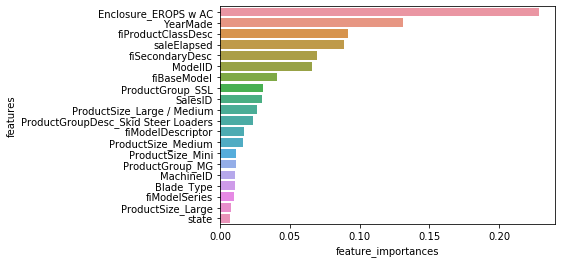

In [34]:
plot_features(X_train.columns, ideal_rfr.feature_importances_)

Then zooming in, turning it into a bar plot and then find where it becomes flat (~0.005).

let’s just try grabbing the columns where it is greater than 0.005, create a new data frame called df_keep which is df_train with just those kept columns, create a new training and validation sets with just those columns, create a new random forest, and look to see how the validation set score. 

In [35]:
fi = pd.DataFrame({'cols':X_train.columns, 'imp':ideal_rfr.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi[:10]

,cols,imp
59,Enclosure_EROPS w AC,0.228667
5,YearMade,0.131384
12,fiProductClassDesc,0.091448
32,saleElapsed,0.089053
9,fiSecondaryDesc,0.069767
2,ModelID,0.065617
8,fiBaseModel,0.040916
43,ProductGroup_SSL,0.031089
0,SalesID,0.030124
37,ProductSize_Large / Medium,0.026219


In [36]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

23

In [39]:
X_train_keep = df_train[to_keep].copy()
X_val_keep = df_val[to_keep].copy()

X_train_keep.shape, X_val_keep.shape

((401125, 23), (11573, 23))

In [41]:
new_rfr = RandomForestRegressor(n_estimators=40,
                                  min_samples_leaf=1,
                                  min_samples_split=6,
                                  max_features='auto',
                                  max_depth=None,
                                  n_jobs=-1,
                                  max_samples=None,
                                  random_state=42) # random state so our results are reproducible

new_rfr.fit(X_train_keep, y_train)
show_scores(new_rfr, X_train_keep, y_train, X_val_keep, y_valid)

{'Training Score': 0.9776949953088898,
 'Valid Score': 0.5689502558080058,
 'Training MAE': 2110.718200715059,
 'Valid MAE': 11213.916229772352,
 'Training RMSLE': 0.10894936118176218,
 'Valid RMSLE': 0.43541330233308845,
 'Training R^2': 0.9776949953088899,
 'Valid R^2': 0.5689502558080057}

So I removed the features with < 0.005 importance and the validation score did better. Now we have a better and simpler model.

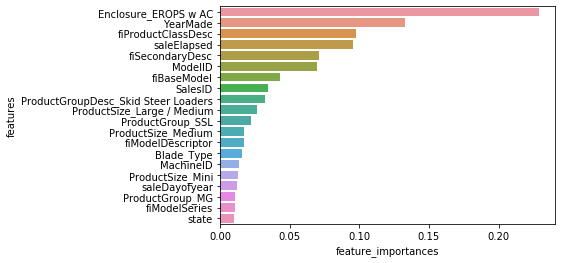

In [42]:
plot_features(X_train_keep.columns, new_rfr.feature_importances_)

## Exploratory Data Analysis from Feature Importance

(Using a copy of `df_orig`, but using `df_train` and `df_test` when necessary)

### Distribution of bulldozers by the Year they were made

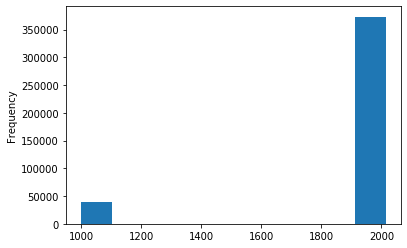

In [58]:
df_orig.YearMade.plot.hist()

In [59]:
print(df_orig[df_orig['YearMade'] == 1000].shape)
print(df_test[df_test['YearMade'] == 1000].shape)

(39391, 65)
(1637, 146)


There are more than 41k rows with a `YearMade` of 1000, between the train/validation and test datasets, which is very wierd.
What happened here? They definitely aren´t typos, and these bulldozers weren’t actually made in the year 1000. There are there for a reason; they must have a reason to have these values. We should consult with the owners of the data; to whom extracted or inserted this data.
What should we do with those rows? In order to understand this plot better, I’m just going to remove them from this interpretation section of the analysis.

In [60]:
# Checking the real minimum and maximum years that the data has
df_orig[df_orig['YearMade'] != 1000]['YearMade'].min(), df_orig['YearMade'].max()

(1919, 2014)

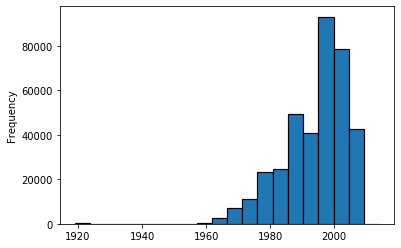

In [61]:
df_orig[df_orig['YearMade'] >= 1919]['YearMade'].plot.hist(bins=20,
                                                               edgecolor='black', linewidth=1.2)

**Warning:** We see that there are rows added to the dataset before 2012, which contradicts the data description provided for the Kaggle competition. Let´s see how many of them are.

In [62]:
df_orig[df_orig['YearMade'] > 2012]['YearMade'].value_counts()

2014    2
2013    1
Name: YearMade, dtype: int64

In [63]:
df_test[df_test['YearMade'] > 2012]['YearMade'].value_counts()

2014    1
Name: YearMade, dtype: int64

Hopefully, they are only 4 rows. Should we drop them?

So one obvious thing we could do would be to plot `YearMade` against `saleElapsed` because seems to make sense that they are both important but it seems very likely that they are combined together to find how old was the product when it was sold. So we could try plotting YearMade against saleElapsed to see how they relate to each other.

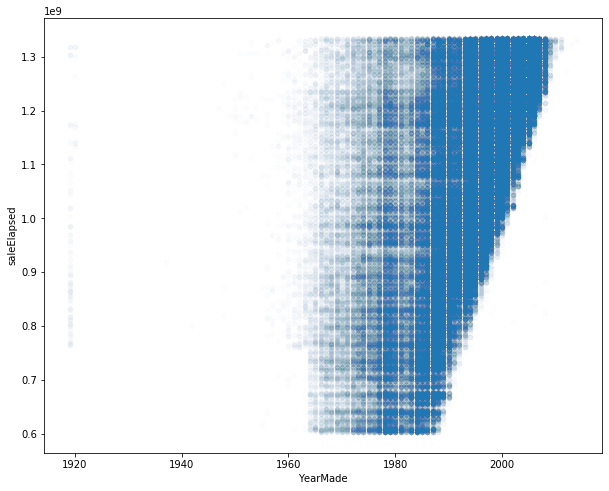

In [74]:
new_orig = df_orig[df_orig['YearMade'] >= 1919]
new_orig.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

### Checking ProductSize

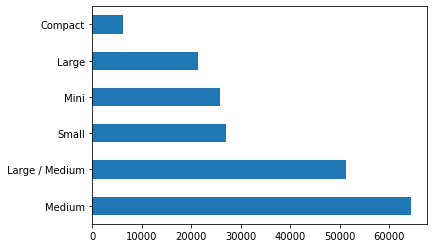

In [64]:
df_orig['ProductSize'].value_counts().plot.barh()

### Checking fiSecondaryDesc

In [65]:
df_orig['fiSecondaryDesc'].value_counts()

C         44431
B         40165
G         37915
H         24729
E         21532
          ...  
BLGPPS        1
HX            1
CKB           1
CLR           1
NLC           1
Name: fiSecondaryDesc, Length: 177, dtype: int64

There are 177 categories of this feature. We´ll try to reduce this amount to those who were most sold.

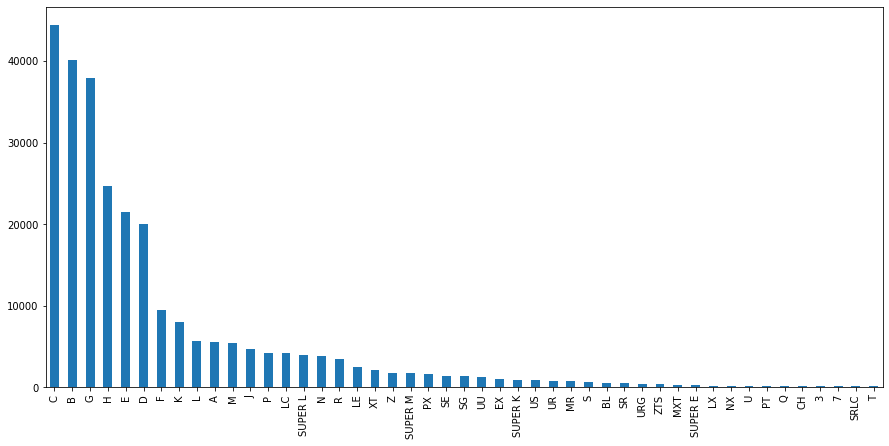

In [66]:
dsc = df_orig['fiSecondaryDesc'].value_counts()
dsc[dsc > 100].plot.bar(figsize=(15,7))

### Checking Enclosure

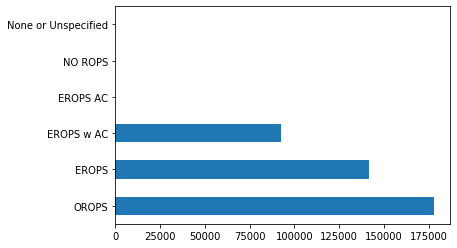

In [67]:
df_orig['Enclosure'].value_counts().plot.barh()

In [68]:
df_orig[df_orig['Enclosure'].isin(['None or Unspecified', 'NO ROPS', 'EROPS AC'])]['Enclosure'].value_counts()

EROPS AC               18
NO ROPS                 3
None or Unspecified     2
Name: Enclosure, dtype: int64

Those `Enclosure` values are negligibles.

# TODO: CHECK THE RMSLE FORMULA